### Predicting the Stock Market using Python

In [2]:
import pandas as pd
import yfinance as yf


In [41]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

## Cleaning and Visualizing Stock Market Data

Index is datetime

<Axes: xlabel='Date'>

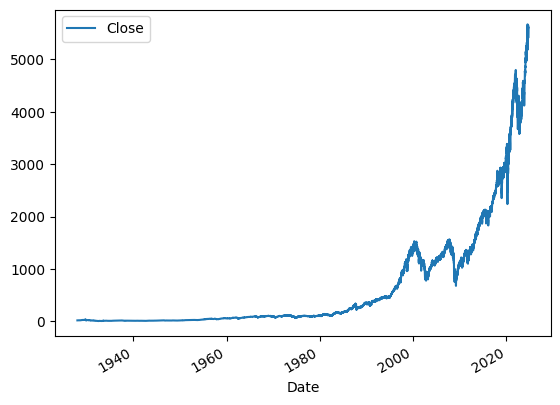

In [42]:
sp500.plot.line(y="Close", use_index = True)

In [43]:
#As the S&P500 is a index they do not do divdends and stock splits so we can remove these redundant columns, these are more appropiate for individual stocks and not indexs
del sp500["Dividends"]
del sp500["Stock Splits"]

## Setup target predictor

In [44]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

#Our Target predictor will be whether or not the price will go up tomorrow
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)


In [45]:
#Stock market may have fundamentally changed through history

sp500 = sp500.loc["1990-01-01":].copy()

## Training the initial machine learning model

In [46]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [47]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

1.0

In [48]:
precision_score(test["Target"], preds)


1.0

<Axes: xlabel='Date'>

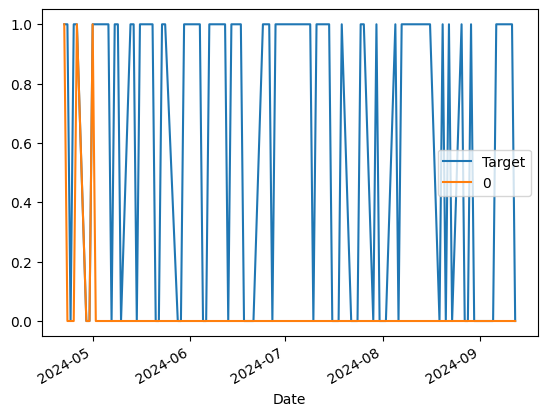

In [49]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

## Backtesting

What do we want to achieve with backtesting?

How do we backtest?

- We set our start to 2500 which is roughly 10 years of data, then our step is 250 meaning that we then predict then next year of data
- After our first model is done, we use the first 11 years of data and then predict the 12th
- After this take the first 12 years of data, predict the 13th etc
- This way we will have predictions for lots of different years and have more confidence in our model

In [50]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds,index=test.index, name ="Predictions")
    combined = pd.concat([test["Target"], preds] , axis = 1)
    return combined


In [93]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions=[]
    count = 0
    for i in range(start, data.shape[0], step):
        count +=1
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train,test, predictors, model)
        all_predictions.append(predictions)
    print(count)
    return pd.concat(all_predictions)

This backtesting runs 21 times, meaning that we do predictions for 21 years, this tests our model throughly against different market conditions

In [94]:
predictions = backtest(sp500, model, predictors)


21


In [53]:
predictions["Predictions"].value_counts()


Predictions
0    3645
1    2596
Name: count, dtype: int64

In [54]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

## Addiding Additional Predictors - Rolling Averages

In [55]:
horizons = [2,5,60,250,1000]
new_predictors = []

#Adding two new predictors

#1 - Ratio : 

#2 - Trend : The number of days in the given horizon in which the close price has gone up

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"]/rolling_averages["Close"]

    trend_column  = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"] #Rolling sum of Target in the last horizon days
    new_predictors+= [ratio_column, trend_column]

In [56]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-06 00:00:00-04:00,5507.330078,5522.470215,5402.620117,5408.419922,3822800000,5471.049805,1,0.991295,0.0,0.979459,1.0,0.983825,34.0,1.084735,143.0,1.246199,524.0
2024-09-09 00:00:00-04:00,5442.069824,5484.200195,5434.490234,5471.049805,3825940000,5495.520020,1,1.005757,1.0,0.997207,1.0,0.995066,34.0,1.096431,143.0,1.260025,525.0
2024-09-10 00:00:00-04:00,5490.509766,5497.910156,5441.720215,5495.520020,3848180000,5554.129883,1,1.002231,2.0,1.002888,2.0,0.999330,34.0,1.100423,144.0,1.265038,526.0


In [57]:
sp500 = sp500.dropna()

In [58]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-05 00:00:00-04:00,5520.080078,5546.299805,5480.540039,5503.410156,3521650000,5408.419922,0,0.998489,0.0,0.990079,1.0,1.001204,35.0,1.104629,144.0,1.268674,525.0
2024-09-06 00:00:00-04:00,5507.330078,5522.470215,5402.620117,5408.419922,3822800000,5471.049805,1,0.991295,0.0,0.979459,1.0,0.983825,34.0,1.084735,143.0,1.246199,524.0
2024-09-09 00:00:00-04:00,5442.069824,5484.200195,5434.490234,5471.049805,3825940000,5495.520020,1,1.005757,1.0,0.997207,1.0,0.995066,34.0,1.096431,143.0,1.260025,525.0


## Improving the model

In [59]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [60]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] #Return probaility of going up/down
    preds[preds>=0.6 ] =1 #Setting this to 0.6 means that when we actually predict a 1, we are more confident it actually goes up, this reduces trading days
    preds[preds<=0.6 ] =0
    preds = pd.Series(preds,index=test.index, name ="Predictions")
    combined = pd.concat([test["Target"], preds] , axis = 1)
    return combined


In [61]:
predictions = backtest(sp500, model, new_predictors)

In [62]:
predictions["Predictions"].value_counts()

#Notice now that there is fewer days where we predict the price to go up

Predictions
0.0    4395
1.0     845
Name: count, dtype: int64

In [63]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5739644970414202

In [64]:
print(predictions)

                           Target  Predictions
Date                                          
2003-11-14 00:00:00-05:00       0          0.0
2003-11-17 00:00:00-05:00       0          1.0
2003-11-18 00:00:00-05:00       1          1.0
2003-11-19 00:00:00-05:00       0          0.0
2003-11-20 00:00:00-05:00       1          1.0
...                           ...          ...
2024-09-05 00:00:00-04:00       0          0.0
2024-09-06 00:00:00-04:00       1          0.0
2024-09-09 00:00:00-04:00       1          0.0
2024-09-10 00:00:00-04:00       1          1.0
2024-09-11 00:00:00-04:00       1          1.0

[5240 rows x 2 columns]


## Feature Importance Analysis

In [65]:
import time

import numpy as np

start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.006 seconds


In [66]:
train.columns
print(new_predictors)

['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']


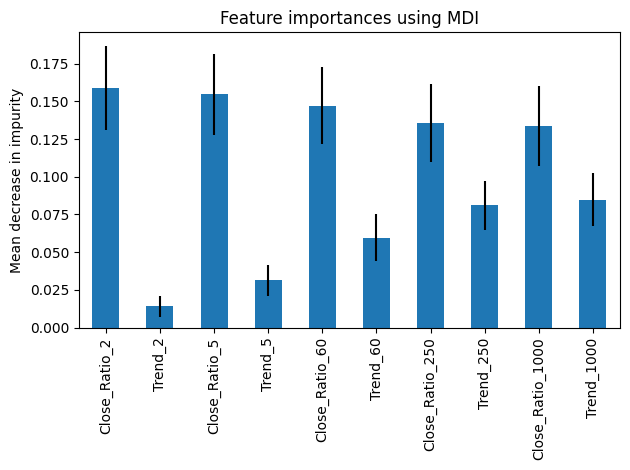

In [67]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=new_predictors)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Improving the model


- There are other exchanges that are open before the S&P500 we could get data from there and see if we can correlate those price changes to S&P500
- Include news 
- Include key components of S&P500, we know that currently a lot of the movement in the S&P500 is due to the tech sector, do some analysis on tech sector performance and correlate to overall S&P500
- 

<Axes: xlabel='Date'>

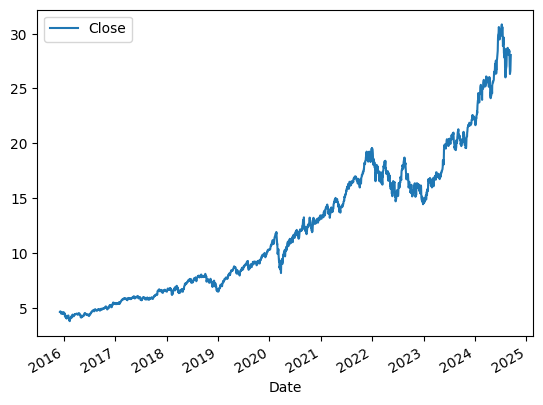

In [176]:
QDVE = yf.Ticker("QDVE.DE")


tech = QDVE.history(period="max")
tech.plot.line(y="Close", use_index = True)


In [177]:
# sp500.value_counts()
tech


del tech["Dividends"]
del tech["Stock Splits"]
del tech["Capital Gains"]

In [178]:
tech.index

DatetimeIndex(['2015-12-03 00:00:00+01:00', '2015-12-04 00:00:00+01:00',
               '2015-12-07 00:00:00+01:00', '2015-12-08 00:00:00+01:00',
               '2015-12-09 00:00:00+01:00', '2015-12-10 00:00:00+01:00',
               '2015-12-11 00:00:00+01:00', '2015-12-15 00:00:00+01:00',
               '2015-12-17 00:00:00+01:00', '2015-12-18 00:00:00+01:00',
               ...
               '2024-08-30 00:00:00+02:00', '2024-09-02 00:00:00+02:00',
               '2024-09-03 00:00:00+02:00', '2024-09-04 00:00:00+02:00',
               '2024-09-05 00:00:00+02:00', '2024-09-06 00:00:00+02:00',
               '2024-09-09 00:00:00+02:00', '2024-09-10 00:00:00+02:00',
               '2024-09-11 00:00:00+02:00', '2024-09-12 00:00:00+02:00'],
              dtype='datetime64[ns, Europe/Berlin]', name='Date', length=2227, freq=None)

In [179]:
dict = {'Open': 'Open_tech',
        'High': 'High_tech',
        'Low': 'Low_tech',
        'Close' : 'Close_tech',
        'Volume' : 'Volume_tech'}

tech.rename(columns=dict, inplace=True)

## Setting up tech variable

In [180]:
tech.index = tech.index.strftime('%d-%m-%Y')

In [181]:
tech["Tomorrow_tech"] = tech["Close_tech"].shift(-1)

#Our Target predictor will be whether or not the price will go up tomorrow
tech["Target_tech"] = (tech["Tomorrow_tech"] > tech["Close_tech"]).astype(int)


In [182]:
tech

,Open_tech,High_tech,Low_tech,Close_tech,Volume_tech,Tomorrow_tech,Target_tech
Date,,,,,,,
03-12-2015,4.767000,4.767000,4.632000,4.632000,100,4.655000,1
04-12-2015,4.655000,4.655000,4.655000,4.655000,0,4.674000,1
07-12-2015,4.723000,4.723000,4.674000,4.674000,12615,4.652000,0
08-12-2015,4.677000,4.677000,4.652000,4.652000,1,4.594000,0
09-12-2015,4.594000,4.594000,4.594000,4.594000,0,4.581000,0
...,...,...,...,...,...,...,...
06-09-2024,26.665001,26.985001,26.235001,26.315001,456177,26.600000,1
09-09-2024,26.610001,26.775000,26.379999,26.600000,388852,27.004999,1
10-09-2024,26.709999,27.080000,26.645000,27.004999,170543,27.094999,1


## Predicting using only data with sector trend data

In [183]:
tech #tech data starts from: 2015-12-03

sp500_tech = sp500.loc["2015-12-03":].copy()
sp500_tech.index = sp500_tech.index.strftime('%d-%m-%Y')
sp500_tech = sp500_tech.join(tech, on="Date")
sp500_tech



,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,Trend_250,Close_Ratio_1000,Trend_1000,Open_tech,High_tech,Low_tech,Close_tech,Volume_tech,Tomorrow_tech,Target_tech
Date,,,,,,,,,,,,,,,,,,,,,
03-12-2015,2080.709961,2085.000000,2042.349976,2049.620117,4306490000,2091.689941,1,0.992761,0.0,0.985178,...,118.0,1.176366,541.0,4.767000,4.767000,4.632000,4.632000,100.0,4.655000,1.0
04-12-2015,2051.239990,2093.840088,2051.239990,2091.689941,4214910000,2077.070068,0,1.010159,1.0,1.005247,...,119.0,1.199915,542.0,4.655000,4.655000,4.655000,4.655000,0.0,4.674000,1.0
07-12-2015,2090.419922,2090.419922,2066.780029,2077.070068,4043820000,2063.590088,0,0.996493,1.0,0.998541,...,119.0,1.190937,542.0,4.723000,4.723000,4.674000,4.674000,12615.0,4.652000,0.0
08-12-2015,2073.389893,2073.850098,2052.320068,2063.590088,4173570000,2047.619995,0,0.996744,0.0,0.995799,...,119.0,1.182633,541.0,4.677000,4.677000,4.652000,4.652000,1.0,4.594000,0.0
09-12-2015,2061.169922,2080.330078,2036.530029,2047.619995,4385250000,2052.229980,1,0.996115,0.0,0.991143,...,118.0,1.172924,540.0,4.594000,4.594000,4.594000,4.594000,0.0,4.581000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05-09-2024,5520.080078,5546.299805,5480.540039,5503.410156,3521650000,5408.419922,0,0.998489,0.0,0.990079,...,144.0,1.268674,525.0,26.905001,27.309999,26.590000,26.879999,271869.0,26.315001,0.0
06-09-2024,5507.330078,5522.470215,5402.620117,5408.419922,3822800000,5471.049805,1,0.991295,0.0,0.979459,...,143.0,1.246199,524.0,26.665001,26.985001,26.235001,26.315001,456177.0,26.600000,1.0
09-09-2024,5442.069824,5484.200195,5434.490234,5471.049805,3825940000,5495.520020,1,1.005757,1.0,0.997207,...,143.0,1.260025,525.0,26.610001,26.775000,26.379999,26.600000,388852.0,27.004999,1.0


## Adding rolling averages to tech sector data

In [184]:
sp500_tech

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,Trend_250,Close_Ratio_1000,Trend_1000,Open_tech,High_tech,Low_tech,Close_tech,Volume_tech,Tomorrow_tech,Target_tech
Date,,,,,,,,,,,,,,,,,,,,,
03-12-2015,2080.709961,2085.000000,2042.349976,2049.620117,4306490000,2091.689941,1,0.992761,0.0,0.985178,...,118.0,1.176366,541.0,4.767000,4.767000,4.632000,4.632000,100.0,4.655000,1.0
04-12-2015,2051.239990,2093.840088,2051.239990,2091.689941,4214910000,2077.070068,0,1.010159,1.0,1.005247,...,119.0,1.199915,542.0,4.655000,4.655000,4.655000,4.655000,0.0,4.674000,1.0
07-12-2015,2090.419922,2090.419922,2066.780029,2077.070068,4043820000,2063.590088,0,0.996493,1.0,0.998541,...,119.0,1.190937,542.0,4.723000,4.723000,4.674000,4.674000,12615.0,4.652000,0.0
08-12-2015,2073.389893,2073.850098,2052.320068,2063.590088,4173570000,2047.619995,0,0.996744,0.0,0.995799,...,119.0,1.182633,541.0,4.677000,4.677000,4.652000,4.652000,1.0,4.594000,0.0
09-12-2015,2061.169922,2080.330078,2036.530029,2047.619995,4385250000,2052.229980,1,0.996115,0.0,0.991143,...,118.0,1.172924,540.0,4.594000,4.594000,4.594000,4.594000,0.0,4.581000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05-09-2024,5520.080078,5546.299805,5480.540039,5503.410156,3521650000,5408.419922,0,0.998489,0.0,0.990079,...,144.0,1.268674,525.0,26.905001,27.309999,26.590000,26.879999,271869.0,26.315001,0.0
06-09-2024,5507.330078,5522.470215,5402.620117,5408.419922,3822800000,5471.049805,1,0.991295,0.0,0.979459,...,143.0,1.246199,524.0,26.665001,26.985001,26.235001,26.315001,456177.0,26.600000,1.0
09-09-2024,5442.069824,5484.200195,5434.490234,5471.049805,3825940000,5495.520020,1,1.005757,1.0,0.997207,...,143.0,1.260025,525.0,26.610001,26.775000,26.379999,26.600000,388852.0,27.004999,1.0


In [185]:
horizons = [2,5,60,250]
new_predictors_tech = []

#Adding two new predictors

#1 - Ratio : 

#2 - Trend : The number of days in the given horizon in which the close price has gone up

for horizon in horizons:
    rolling_averages = sp500_tech.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}_tech"
    sp500_tech[ratio_column] = sp500_tech["Close_tech"]/rolling_averages["Close_tech"]

    trend_column  = f"Trend_{horizon}_tech"
    sp500_tech[trend_column] = sp500_tech.shift(1).rolling(horizon).sum()["Target_tech"] #Rolling sum of Target in the last horizon days
    new_predictors_tech+= [ratio_column, trend_column]

In [186]:
sp500_tech

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,Tomorrow_tech,Target_tech,Close_Ratio_2_tech,Trend_2_tech,Close_Ratio_5_tech,Trend_5_tech,Close_Ratio_60_tech,Trend_60_tech,Close_Ratio_250_tech,Trend_250_tech
Date,,,,,,,,,,,,,,,,,,,,,
03-12-2015,2080.709961,2085.000000,2042.349976,2049.620117,4306490000,2091.689941,1,0.992761,0.0,0.985178,...,4.655000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04-12-2015,2051.239990,2093.840088,2051.239990,2091.689941,4214910000,2077.070068,0,1.010159,1.0,1.005247,...,4.674000,1.0,1.002477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07-12-2015,2090.419922,2090.419922,2066.780029,2077.070068,4043820000,2063.590088,0,0.996493,1.0,0.998541,...,4.652000,0.0,1.002037,2.0,NaN,NaN,NaN,NaN,NaN,NaN
08-12-2015,2073.389893,2073.850098,2052.320068,2063.590088,4173570000,2047.619995,0,0.996744,0.0,0.995799,...,4.594000,0.0,0.997641,1.0,NaN,NaN,NaN,NaN,NaN,NaN
09-12-2015,2061.169922,2080.330078,2036.530029,2047.619995,4385250000,2052.229980,1,0.996115,0.0,0.991143,...,4.581000,0.0,0.993727,0.0,0.989788,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05-09-2024,5520.080078,5546.299805,5480.540039,5503.410156,3521650000,5408.419922,0,0.998489,0.0,0.990079,...,26.315001,0.0,0.997680,0.0,0.972574,2.0,0.932988,35.0,NaN,NaN
06-09-2024,5507.330078,5522.470215,5402.620117,5408.419922,3822800000,5471.049805,1,0.991295,0.0,0.979459,...,26.600000,1.0,0.989379,0.0,0.967606,1.0,0.914493,34.0,NaN,NaN
09-09-2024,5442.069824,5484.200195,5434.490234,5471.049805,3825940000,5495.520020,1,1.005757,1.0,0.997207,...,27.004999,1.0,1.005386,1.0,0.989583,2.0,0.925733,34.0,NaN,NaN


In [187]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [188]:
all_predictors = new_predictors + new_predictors_tech
all_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_2_tech',
 'Trend_2_tech',
 'Close_Ratio_5_tech',
 'Trend_5_tech',
 'Close_Ratio_60_tech',
 'Trend_60_tech',
 'Close_Ratio_250_tech',
 'Trend_250_tech']

In [217]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    # Method 1 - Use 0.5 as the decision boundry for up/down
    preds = model.predict(test[predictors])
    preds = pd.Series(preds,index=test.index, name ="Predictions")
    
    
    # Method 2 - Use 0.5 as the decision boundry for up/down
    # preds = model.predict_proba(test[predictors])[:,1] #Return probaility of going up/down
    # print(preds)[:200]
    # preds[preds>=0.6 ] =1 #Setting this to 0.6 means that when we actually predict a 1, we are more confident it actually goes up, this reduces trading days
    # preds[preds<=0.6 ] =0
    # preds = pd.Series(preds,index=test.index, name ="Predictions")

    ##Keep everything else the same
    combined = pd.concat([test["Target"], preds] , axis = 1)
    return combined

In [218]:
train = sp500_tech.iloc[0:1800].copy()
test = sp500_tech.iloc[1800:].copy()
predictions = predict(train,test, predictors, model)

[0.44900524 0.4942024  0.35697722 0.5093365  0.57376975 0.44076337
 0.35483066 0.52596815 0.51003552 0.51730743 0.35250949 0.43050711
 0.31996745 0.40426832 0.45395265 0.39424611 0.40542925 0.45224018
 0.5331422  0.44490855 0.38593548 0.52112981 0.45095411 0.4498318
 0.43115954 0.44481912 0.44186803 0.35338793 0.4348163  0.40052645
 0.59399837 0.46051725 0.62221117 0.40745116 0.51731192 0.40615314
 0.46722505 0.37156852 0.42054847 0.42414667 0.45562558 0.39859556
 0.47840878 0.46406264 0.37393909 0.44755659 0.46563723 0.44927866
 0.3640333  0.45374298 0.47546188 0.4092497  0.54917823 0.5502702
 0.49792846 0.51564905 0.56330309 0.59183037 0.41228382 0.48203132
 0.41634337 0.44215137 0.38825816 0.39405827 0.51995206 0.42017788
 0.42315673 0.35507104 0.56806942 0.54184687 0.45193741 0.55321701
 0.53885424 0.47400037 0.5126487  0.35499861 0.50224397 0.45864936
 0.48865375 0.4489458  0.57376591 0.39067159 0.51237948 0.40182204
 0.54275053 0.53289795 0.68526386 0.70731865 0.6012862  0.681870

TypeError: 'NoneType' object is not subscriptable

In [215]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5691056910569106

In [205]:
all_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_2_tech',
 'Trend_2_tech',
 'Close_Ratio_5_tech',
 'Trend_5_tech',
 'Close_Ratio_60_tech',
 'Trend_60_tech',
 'Close_Ratio_250_tech',
 'Trend_250_tech']

## Analysis of results

In the following code I have plotted a graph of Target and Predictions as well as a confusion matrix where we can see an in depth view in where our model is making errors

- From the confusion matrix our most common source of error is when our model wrongly predicts no upwards movement when actually the stock price moves up
- In the first graph we notice that there may be something wrong in our dataset as all predictions are 0 from a given date, this can account for a lot of the error that we can

<Axes: xlabel='Date'>

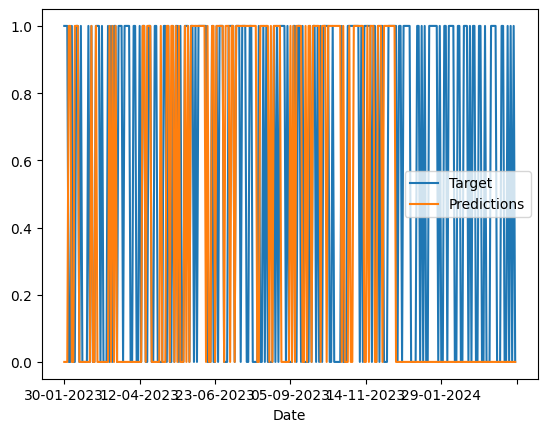

In [216]:
combined = pd.concat([predictions["Target"][:300], predictions["Predictions"][:300]], axis=1)
combined.plot()

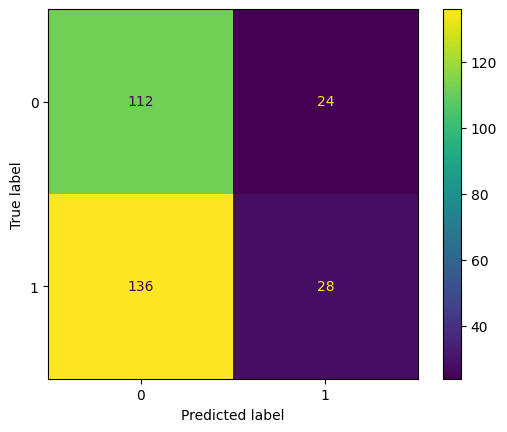

In [207]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



cm = confusion_matrix(predictions["Target"][:300], predictions["Predictions"][:300], labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

In [ ]:
preds = model.predict_proba(sp500_tech[predictors])[:,1] #Return probaility of going up/down